In [75]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from typing import List, Optional

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- Outputs is a list of (num_baselines x num_trials) dicts
- Each dict has the following keys and values:
    - 'problem_name': string indicating problem name
    - 'trial_index': index of trial
    - 'methods': list of method(s)
    - 'exp_candidate_results': dict with key "method__pestrategy", value a list of dicts logging results (e.g., `best_util_so_far`) at each `BO_iter`
    - 'PE_session_results': dict with key "method__pestrategy", value a list of dicts logging results at each `n_comps`. Result metrics include:
        - `util`
        - `util_model_acc`
        - `util_model_acc_top_half`
        - `util_model_acc_top_quarter`
        - `overall_model_acc`
    - 'subspace_diagnostics': dict with key "method__pestrategy", value a dict logging a list of floats for different diagnostics, including:
        - `rel_mse`
        - `max_util_error`
        - `max_outcome_error`
        - `best_util`
        - `avg_util`
    - 'pref_data_dict'
    - 'BO_data_dict'


In [129]:
# problem = "8by8_rectangle_gradientAwareArea"
problem = "16by16_rectangle_gradientAwareArea"
# problem = "vehiclesafety_5d3d_piecewiselinear_24"
# problem = "carcabdesign_7d9d_linear_72"
prefix = "0509_"

file = f"../../experiments/FBLEARNER/{problem}/{prefix}{problem}.json"

outputs = json.load(
    open(file)
)

## Code and configurations for making plots

In [48]:
colors_dict = {
    "pca": "tab:red", 
    "pca_rt": "tab:pink",
    "wpca_est_rt": "tab:orange",
    "st": "tab:blue", 
    "random_linear_proj": "tab:green", 
    "random_search": "tab:cyan",
}
labels_dict = {
    "st": "Indep", 
    "pca": "PCA", 
    "pca_rt": "PCA retraining",
    "wpca_est_rt": "weighted PCA using utility posterior mean",
    "random_linear_proj": "Rand-linear-proj", 
    "random_search": "Random search"
}

In [81]:
from collections import defaultdict 


def plot_BO_PE_performance(
    outputs: List[dict],
    methods: List[str],
    type: str, # "BO" or "PE"
    y_metric: str,
    title: str,
    x_metric: Optional[str] = None,
    x_label: Optional[str] = None,
    y_label: Optional[str] = None,
): 

    if type == "BO":
        subdict_name = "exp_candidate_results"
    elif type == "PE":
        subdict_name = "PE_session_results"

    # extract a list of methods
    method_res = [outputs[i]["methods"][0] for i in range(len(outputs))]

    #  a dict mapping method to list of trials
    method_indices = defaultdict(list)

    for i, method in enumerate(method_res):
        method_indices[method].append(i)

    method_indices = dict(method_indices)

    for method in methods:
        res = [outputs[i][subdict_name][f"{method}__EUBO-zeta"] for i in method_indices[method]]


        all_res = []

        for i in range(len(res)):

            all_res.append(pd.DataFrame(res[i])[y_metric].values)

        data_np = np.array(all_res)

        # use a masked array to handle missing data
        lens = [len(data_np[i]) for i in range(len(data_np))]
        arr = np.ma.empty((np.max(lens),len(data_np)))
        arr.mask = True
        for idx, l in enumerate(data_np):
            arr[:len(l),idx] = l
        
        mean = arr.mean(axis=-1)
        sem = arr.std(axis=-1, ddof=1) / np.sqrt(arr.shape[-1])

        if x_metric is not None:
            x_values = pd.DataFrame(res[0])[x_metric].values
        else:
            x_values = range(len(mean))

        plt.plot(x_values, mean, color = colors_dict[method], label = labels_dict[method])
        plt.fill_between(
            x_values,
            mean - sem,
            mean + sem,
            alpha=0.2,
            color=colors_dict[method],
        )

    plt.legend()

    plt.title(title)

    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
        

## Plot BO performance

/tmp/ipykernel_1810310/2316547987.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_np = np.array(all_res)


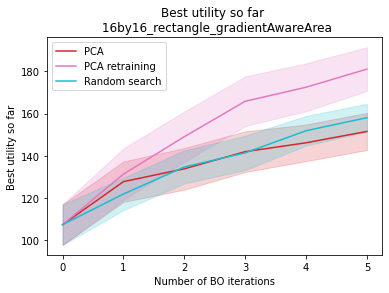

In [130]:
plot_BO_PE_performance(
    outputs,
    methods = [
        # "st", 
        "pca", 
        "pca_rt", 
        "random_search"
    ],
    type = "BO",
    y_metric = "best_util_so_far",
    title = f"Best utility so far \n {problem}",
    x_label = "Number of BO iterations",
    y_label = "Best utility so far",
)

## Plot PE performance

/tmp/ipykernel_1810310/2316547987.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_np = np.array(all_res)


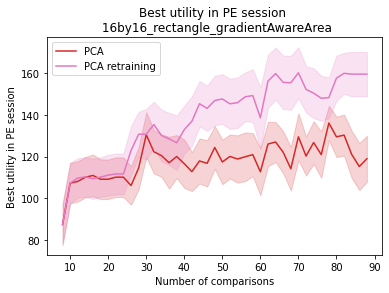

In [131]:
plot_BO_PE_performance(
    outputs,
    methods = [
        # "st", 
        "pca", 
        "pca_rt", 
        # "random_search"
    ],
    type = "PE",
    y_metric = "util",
    title = f"Best utility in PE session \n {problem}",
    x_metric = "n_comps",
    x_label = "Number of comparisons",
    y_label = "Best utility in PE session",
)

## Plot utility model accuracy

/tmp/ipykernel_1810310/2316547987.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_np = np.array(all_res)


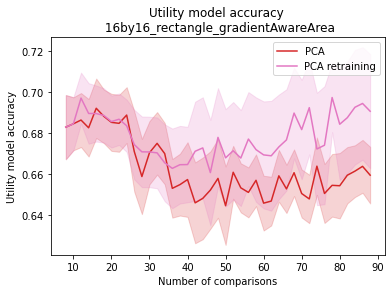

In [132]:
plot_BO_PE_performance(
    outputs,
    methods = [
        # "st", 
        "pca", 
        "pca_rt", 
        # "random_search"
    ],
    type = "PE",
    y_metric = "util_model_acc",
    title = f"Utility model accuracy \n {problem}",
    x_metric = "n_comps",
    x_label = "Number of comparisons",
    y_label = "Utility model accuracy",
)

## Plot overall accuracy of composite model

/tmp/ipykernel_1810310/2316547987.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_np = np.array(all_res)


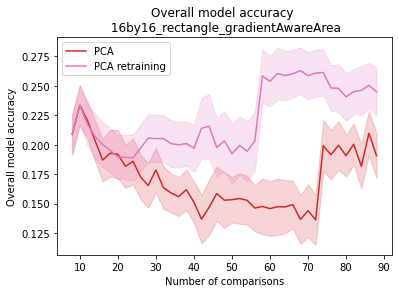

In [133]:
plot_BO_PE_performance(
    outputs,
    methods = [
        # "st", 
        "pca", 
        "pca_rt", 
        # "random_search"
    ],
    type = "PE",
    y_metric = "overall_model_acc",
    title = f"Overall model accuracy \n {problem}",
    x_metric = "n_comps",
    x_label = "Number of comparisons",
    y_label = "Overall model accuracy",
)